# VOC2012数据集
[VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)是一个常用的语义分割数据集。输入图片跟之前的数据集类似，但标注的是保存为相应大小的图片来方便查看。下面代码下载这个数据集并解压，可以预先下好放置在data下。

In [44]:
import requests
from tqdm import tqdm
import os
import warnings
import zipfile
from d2l import torch as d2l

dataroot = './data'
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'

In [4]:
warnings.filterwarnings('ignore')

def download_file(url):
    print("------", "Start download with urllib")
    name = url.split("/")[-1]
    resp = requests.get(url, stream=True)
    content_size = int(resp.headers['Content-Length']) / 1024  # 确定整个安装包的大小
    # 下载到上一级目录
    path = os.path.abspath(os.path.dirname(os.getcwd())) + "\\" + name
    # 下载到该目录
    path = os.getcwd() + "\\" + name
    print("File path:  ", path)
    with open(path, "wb") as file:
        print("File total size is:  ", content_size)
        for data in tqdm(iterable=resp.iter_content(1024), total=content_size, unit='k', desc=name):
            file.write(data)
    print("------", "finish download with urllib\n\n")

In [6]:
download_file(url)

------ Start download with urllib
File path:   E:\Anacondaspace\jupyter notebook\语义分割\FCN\VOCtrainval_11-May-2012.tar
File total size is:   1952772.5


VOCtrainval_11-May-2012.tar: 1952773k [06:44, 4828.32k/s]                                                              

------ finish download with urllib




其实，如果你想要实现代码解压也可以，但考虑到要用这方面的可能也不多，所以我这里是下载好后，在文件当中手动解压

In [22]:
filename = 'VOCdevkit/VOC2012'
vocRoot = os.path.join(dataroot, filename)
print(vocRoot)

./data\VOCdevkit/VOC2012


进入路径../data/VOCdevkit/VOC2012之后，我们可以看到数据集的不同组件。 ImageSets/Segmentation路径包含用于训练和测试样本的文本文件，而JPEGImages和SegmentationClass路径分别存储着每个示例的输入图像和标签。 此处的标签也采用图像格式，其尺寸和它所标注的输入图像的尺寸相同。 此外，标签中颜色相同的像素属于同一个语义类别。 下面将read_voc_images函数定义为将所有输入的图像和标签读入内存。
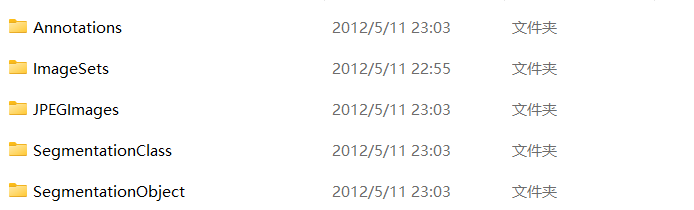

In [61]:
# def read_voc_images(voc_dir, is_train=True):
#     """读取所有VOC图像并标注"""
#     txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
#                              'train.txt' if is_train else 'val.txt')
#     mode = torchvision.io.image.ImageReadMode.RGB
#     with open(txt_fname, 'r') as f:
#         images = f.read().split()
#     features, labels = [], []
#     for i, fname in enumerate(images):
#         features.append(torchvision.io.read_image(os.path.join(
#             voc_dir, 'JPEGImages', f'{fname}.jpg')))
#         labels.append(torchvision.io.read_image(os.path.join(
#             voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
#     return features, labels

train_features, train_labels = d2l.read_voc_images(vocRoot, True)

在这里，我们需要进行对数据的处理

接下来将会绘制前5个输入图像及其标签。 在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。

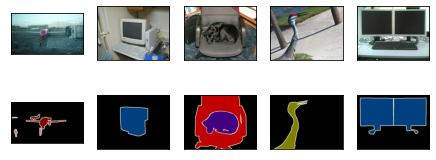

In [46]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]  #画的时候将通道放在后面
d2l.show_images(imgs, 2, n);

接下来，是关于这个数据集的RGB与类别的对应值，怎么理解呢？这里的语义分割是像素级的分割，第一个类背景(background)对应的颜色为黑色([0,0,0])，其他的以此类推。

In [47]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

为了方便地查找标签中每个像素的类索引，d2l定义了voc_colormap2label函数来构建从上述RGB颜色值到类别索引的映射，而voc_label_indices函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。

In [48]:
y = d2l.voc_label_indices(train_labels[0], d2l.voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 预处理数据
我们常通过再缩放图像使其符合模型的输入形状。在语义分割中，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射可能不够精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪为固定尺寸，而不是再缩放。具体来说，我们使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域。

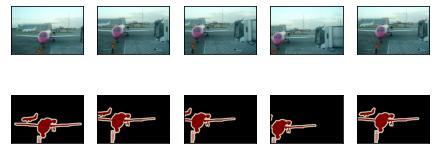

In [54]:
imgs = []
for _ in range(n):
    imgs += d2l.voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### 自定义语义分割数据集类
我们通过继承高级API提供的Dataset类，d2l自定义了一个语义分割数据集类VOCSegDataset。 通过实现__getitem__函数，我们可以任意访问数据集中索引为idx的输入图像及其每个像素的类别索引。由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的filter函数移除掉。 此外，VOCSegDataset还定义了normalize_image函数，从而对输入图像的RGB三个通道的值分别做标准化。

In [55]:
# class VOCSegDataset(torch.utils.data.Dataset):
#     """一个用于加载VOC数据集的自定义数据集"""

#     def __init__(self, is_train, crop_size, voc_dir):
#         self.transform = torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         self.crop_size = crop_size
#         features, labels = read_voc_images(voc_dir, is_train=is_train)
#         self.features = [self.normalize_image(feature)
#                          for feature in self.filter(features)]
#         self.labels = self.filter(labels)
#         self.colormap2label = voc_colormap2label()
#         print('read ' + str(len(self.features)) + ' examples')

#     def normalize_image(self, img):
#         return self.transform(img.float() / 255)

#     def filter(self, imgs):
#         return [img for img in imgs if (
#             img.shape[1] >= self.crop_size[0] and
#             img.shape[2] >= self.crop_size[1])]

#     def __getitem__(self, idx):
#         feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
#                                        *self.crop_size)
#         return (feature, voc_label_indices(label, self.colormap2label))

#     def __len__(self):
#         return len(self.features)

### 读取数据集
d2l通过自定义的VOCSegDataset类来分别创建训练集和测试集的实例。 假设我们指定随机裁剪的输出图像的形状为320 X 480，下面我们可以查看训练集和测试集所保留的样本个数。

In [58]:
crop_size = (320, 480)
VOCSegDataset=d2l.VOCSegDataset
voc_train = VOCSegDataset(True, crop_size, vocRoot)
voc_test = VOCSegDataset(False, crop_size, vocRoot)

read 1114 examples
read 1078 examples


设批量大小为64，我们定义训练集的迭代器。 打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。

In [59]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### 整合所有组件
最后，d2l定义了load_data_voc函数来下载并读取Pascal VOC2012语义分割数据集。 它返回训练集和测试集的数据迭代器。

In [60]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

## 小结
* 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容。

* 语义分割的一个重要的数据集叫做Pascal VOC2012。

* 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放。